# Signal quality metric calculation & Real time signal quality logic

In [9]:
from ppg2rr.riv_est import find_extrema_HX2017
from ppg2rr.signal_quality import template_match_similarity
from ppg2rr import heart_rate as hr
from ppg2rr.util import lowpass_butter
import pandas as pd
import numpy as np
import glob

# Signal Quality Metric

To estimate quality, we first estimate each PPG pulse, then we compare the shapes of each
individual pulse to the average pulse 

Additional information can be found on the wiki: https://github.com/new-horizons/pulseox_pubalgs/wiki/Signal-Quality-Metrics

In [3]:
# As of Jan 8th, 2024, the following function is found in the repo `pulseox_collect`, 
# branch `develop`, under python/collect/experiment_ready_checks.py

# An estimated `pulse_rate` can be calculated using `heart_rate.estimate_average_pulse_rate`

def pulse_shape_consistency(
    ppg: np.ndarray,
    sampling_rate: float,
    pulse_rate: float,
    debug_flag: bool = False,
) -> bool:
    """Returns the consistency of the pulses within the given ppg signal.

    Args:
        ppg (np.ndarray): The pre-processed ppg signal.
        sampling_rate (float): The sampling rate of the ppg signal.
        pulse_rate (float): Estimated pulse rate of the signal, in beats per minute.
        debug_flag: if True, display figures associated with each processing step.

    Returns:
        float, 1 if ppg pulses have high consistency (high quality), 0 if not.
    """
    # Get ppg pulse locations
    max_idx_raw, _ = find_extrema_HX2017(
        ppg,
        sampling_rate,
        hr_bpm=pulse_rate,
        debug_flag=debug_flag,
    )
    
    if len(max_idx_raw) < 5:
        return np.nan
    
    # Quantify the ppg quality
    ppg_quality, _ = template_match_similarity(
        ppg, max_idx_raw, show=debug_flag
    )

    return ppg_quality["pct diagnostic quality pulses"]

# Real time quality check
During data collection, a wrapper function is continuously called to assess the signal quality.
The basic idea is found below:

As of Jan 8th, 2024, the actual wrapper function is found in the repo `pulseox_collect`, 
branch `develop`, under python/collect/experiment_ready_checks.py

In [10]:
sampling_rate = 125
lowpass_cutoff = 4

def show_signal_quality_example(ppg):
    pulse_rate = hr.estimate_avg_heart_rate(
        ppg=ppg,
        sampling_rate=sampling_rate,
        min_heart_rate_hz=50/60,
        show=False
    )

    ppg_filtered = lowpass_butter(
        ppg, sampling_rate, f_max=lowpass_cutoff, show=False
        )
        
    pulse_shape_consistency(
        ppg=ppg_filtered,
        sampling_rate=sampling_rate,
        pulse_rate=pulse_rate,
        debug_flag = True
    )

# Example waveforms

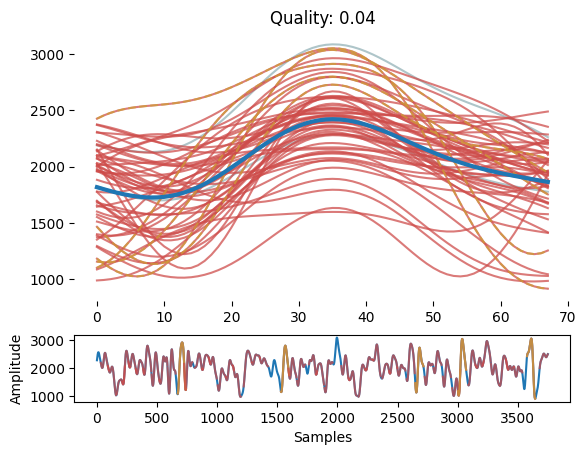

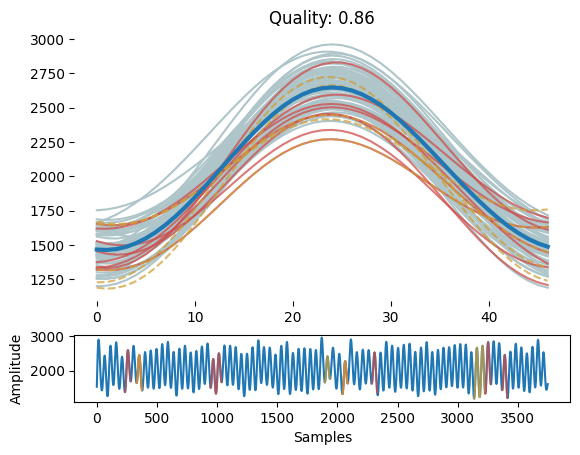

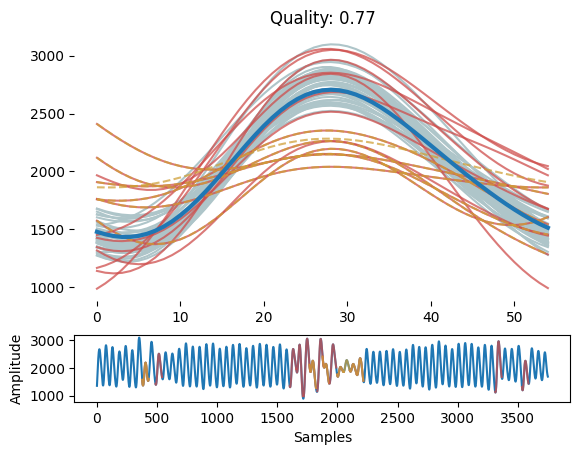

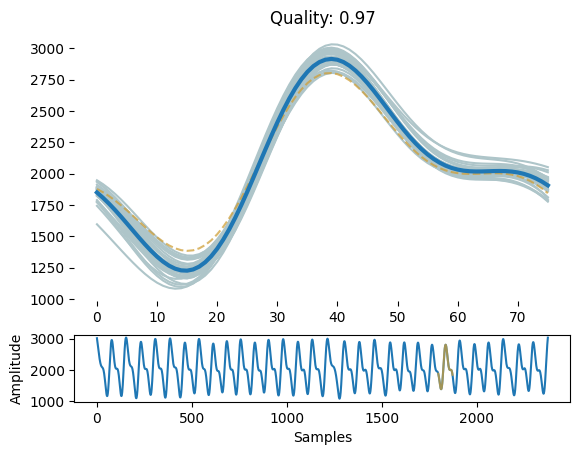

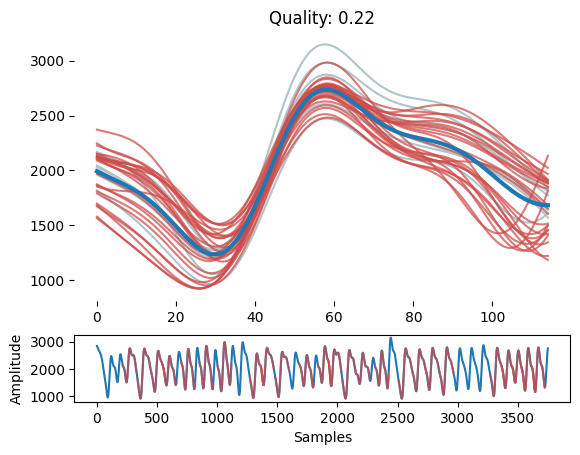

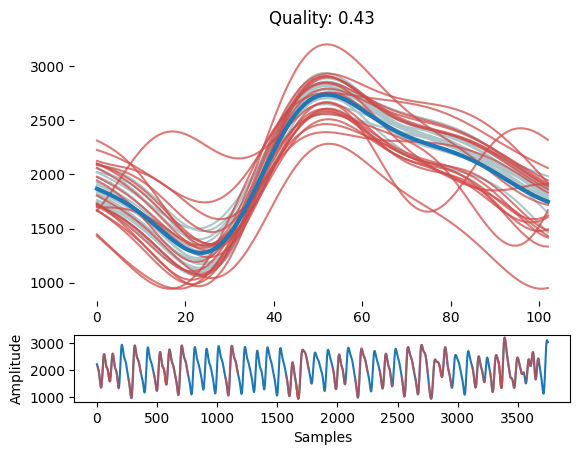

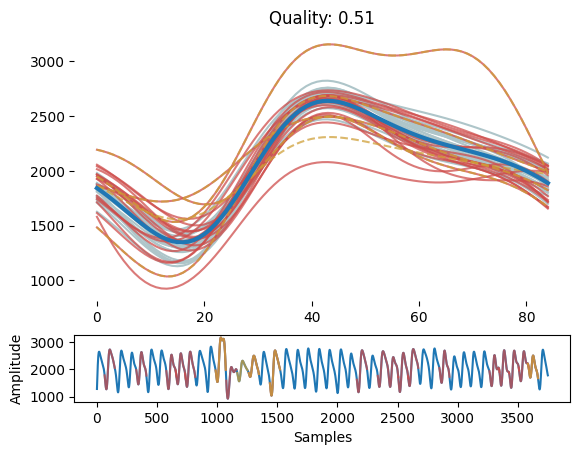

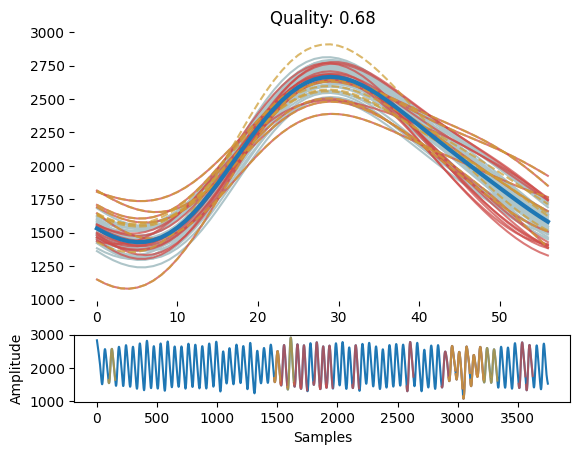

In [11]:
files = glob.glob('../tests/resources/ppg_waveforms/*.csv')

for file in files:
    df = pd.read_csv(file)
    ppg = df['0']
    show_signal_quality_example(ppg)